In [4]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


# Data preprocessing

In [158]:
images=[]
X_train = []
X_test = []

In [152]:
def make_train_data(flower_type):
    DIR = '/' + flower_type + '/'
    current_dir = os.curdir + "/Train" + DIR

    for img in tqdm(os.listdir(current_dir)):
        path = os.path.join(current_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        images.append(img)        
        img = cv2.resize(img, (224,224))
        X_train.append(np.array(img))
        
def make_test_data(flower_type):
    DIR = '/' + flower_type + '/'
    current_dir = os.curdir + "/Test" + DIR

    for img in tqdm(os.listdir(current_dir)):
        path = os.path.join(current_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        images.append(img)        
        img = cv2.resize(img, (224,224))
        X_test.append(np.array(img))
        
        

In [159]:
classes = ['Tana', 'Rosy', 'Pingpong','Lisianthus', 'Hydrangeas', 'Chrysanthemum', 'Calimerio', 'Babi']

for item in classes:
    make_train_data(item)
    make_test_data(item)

100%|███████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 493.79it/s]


In [162]:
X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [163]:
print(X_train.shape)

(3696, 224, 224, 3)


In [188]:
training_dir = os.curdir + '/Train'

# Test data dir
testing_dir = os.curdir + '/Test'

data_gen = ImageDataGenerator(rescale = 1./255)
train_generator = data_gen.flow_from_directory(training_dir, (224,224), batch_size=64, class_mode='input',shuffle=True)
valid_generator = data_gen.flow_from_directory(testing_dir, (224,224), batch_size=64, class_mode='input', shuffle=True)

Found 3696 images belonging to 8 classes.
Found 925 images belonging to 8 classes.


# Base model

In [191]:
input_img = Input(shape=(224, 224, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name=  'encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder2layers = Model(input_img, decoded)
autoencoder2layers.compile(optimizer='adam', loss='mse')
autoencoder2layers.summary()

Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_197 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_198 (Conv2D)         (None, 112, 112, 8)       1160      
                                                                 
 encoder (MaxPooling2D)      (None, 56, 56, 8)         0         
                                                                 
 conv2d_199 (Conv2D)         (None, 56, 56, 8)         584       
                                                          

In [ ]:
history = autoencoder2layers.fit(
        train_generator,
        steps_per_epoch=train_generator.n//64,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//64,
        epochs=10)


Epoch 1/10
57/57 [==============================] - 118s 2s/step - loss: 0.0557 - val_loss: 0.0380
Epoch 2/10
57/57 [==============================] - 109s 2s/step - loss: 0.0212 - val_loss: 0.0147
Epoch 3/10
32/57 [===============>..............] - ETA: 48s - loss: 0.0138

In [44]:
input_img = Input(shape=(224, 224, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name=  'encoder')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder3layers = Model(input_img, decoded)
autoencoder3layers.compile(optimizer='adam', loss='mse')
autoencoder3layers.summary()

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_185 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_186 (Conv2D)         (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 56, 56, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_187 (Conv2D)         (None, 56, 56, 8)         584

In [45]:
history2 = autoencoder3layers.fit(
        (X_train, X_train),
        validation_data=(X_test, X_test),
        batch_size=32,
        epochs=10,
        verbose=1)

Epoch 1/10
57/57 [==============================] - 89s 2s/step - loss: 0.0561 - val_loss: 0.0314
Epoch 2/10
57/57 [==============================] - 88s 2s/step - loss: 0.0248 - val_loss: 0.0222
Epoch 3/10
57/57 [==============================] - 88s 2s/step - loss: 0.0208 - val_loss: 0.0201
Epoch 4/10
57/57 [==============================] - 88s 2s/step - loss: 0.0195 - val_loss: 0.0193
Epoch 5/10
57/57 [==============================] - 88s 2s/step - loss: 0.0186 - val_loss: 0.0184
Epoch 6/10
57/57 [==============================] - 88s 2s/step - loss: 0.0176 - val_loss: 0.0172
Epoch 7/10
57/57 [==============================] - 88s 2s/step - loss: 0.0162 - val_loss: 0.0157
Epoch 8/10
57/57 [==============================] - 88s 2s/step - loss: 0.0154 - val_loss: 0.0153
Epoch 9/10
57/57 [==============================] - 88s 2s/step - loss: 0.0148 - val_loss: 0.0148
Epoch 10/10
57/57 [==============================] - 88s 2s/step - loss: 0.0144 - val_loss: 0.0144


# Query Image

In [93]:
encoder = Model(inputs=autoencoder2layers.input, outputs=autoencoder2layers.get_layer('max_pooling2d_63').output)

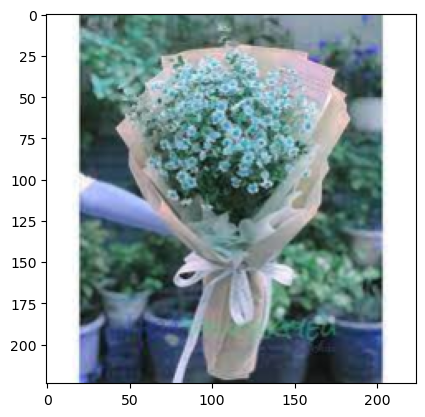

In [164]:
query = X_test[7]
plt.imshow(query)


In [165]:
X_buf = np.delete(X_test, 7, axis=0)

In [169]:
codes = encoder.predict(X_test)

query_code = encoder.predict(query.reshape(1,224,224,3))


1/1 [==============================] - 0s 28ms/step


In [173]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, metric="cosine")

In [174]:
codes = codes.reshape(-1, 56*56*8); print(codes.shape)
query_code = query_code.reshape(1, 56*56*8); print(query_code.shape)

(925, 25088)
(1, 25088)


In [175]:
nbrs = knn.fit(codes)


In [176]:
distances, indices = nbrs.kneighbors(np.array(query_code))


In [182]:
closest_images = X_test[indices]


In [183]:
closest_images = closest_images.reshape(-1,224,224,3); print(closest_images.shape)


(10, 224, 224, 3)


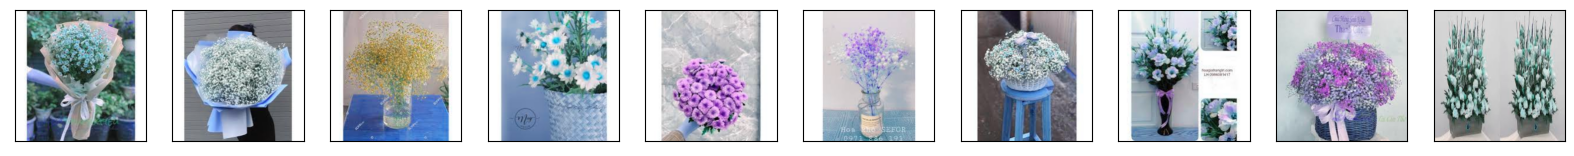

In [184]:
plt.figure(figsize=(20, 6))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(closest_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()